# ICR - Identifying Age-Related Conditions Dataset 

This notebook walks you through how to train a LightGBM on the ICR - Identifying Age-Related Conditions dataset made available for this competition. The goal of the model is to predict if a person has one or more of any of three medical conditions or none.

## Dataset Description
The competition data comprises over fifty anonymized health characteristics linked to three age-related conditions. Your goal is to predict whether a subject has or has not been diagnosed with one of these conditions -- a binary classification problem.

Note that this is a Code Competition, in which the actual test set is hidden. In this version, we give some sample data in the correct format to help you author your solutions. When your submission is scored, this example test data will be replaced with the full test set. There are about 400 rows in the full test set.

Files and Field Descriptions
train.csv - The training set.
Id Unique identifier for each observation.
AB-GL Fifty-six anonymized health characteristics. All are numeric except for EJ, which is categorical.
Class A binary target: 1 indicates the subject has been diagnosed with one of the three conditions, 0 indicates they have not.
test.csv - The test set. Your goal is to predict the probability that a subject in this set belongs to each of the two classes.
greeks.csv - Supplemental metadata, only available for the training set.
Alpha Identifies the type of age-related condition, if present.
A No age-related condition. Corresponds to class 0.
B, D, G The three age-related conditions. Correspond to class 1.
Beta, Gamma, Delta Three experimental characteristics.
Epsilon The date the data for this subject was collected. Note that all of the data in the test set was collected after the training set was collected.
sample_submission.csv - A sample submission file in the correct format. See the Evaluation page for more details.

# Import the libraries

In [4]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split, GridSearchCV

import xgboost as xgb
from sklearn.ensemble import VotingClassifier
from lightgbm import LGBMClassifier
from sklearn.svm import SVC

from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, log_loss, make_scorer

# Load the Dataset

In [5]:
train = pd.read_csv('/kaggle/input/icr-identify-age-related-conditions/train.csv')
greeks = pd.read_csv('/kaggle/input/icr-identify-age-related-conditions/greeks.csv')
print("Full train dataset shape is {}".format(train.shape))

Full train dataset shape is (617, 58)


The data is composed of 58 columns and 617 entries. We can see all 58 dimensions(results will be truncated since the number of columns is big) of our dataset by printing out the first 5 entries using the following code:

In [6]:
train.head()

,Id,AB,AF,AH,AM,AR,AX,AY,AZ,BC,...,FL,FR,FS,GB,GE,GF,GH,GI,GL,Class
0,000ff2bfdfe9,0.209377,3109.03329,85.200147,22.394407,8.138688,0.699861,0.025578,9.812214,5.555634,...,7.298162,1.73855,0.094822,11.339138,72.611063,2003.810319,22.136229,69.834944,0.120343,1
1,007255e47698,0.145282,978.76416,85.200147,36.968889,8.138688,3.632190,0.025578,13.517790,1.229900,...,0.173229,0.49706,0.568932,9.292698,72.611063,27981.562750,29.135430,32.131996,21.978000,0
2,013f2bd269f5,0.470030,2635.10654,85.200147,32.360553,8.138688,6.732840,0.025578,12.824570,1.229900,...,7.709560,0.97556,1.198821,37.077772,88.609437,13676.957810,28.022851,35.192676,0.196941,0
3,043ac50845d5,0.252107,3819.65177,120.201618,77.112203,8.138688,3.685344,0.025578,11.053708,1.229900,...,6.122162,0.49706,0.284466,18.529584,82.416803,2094.262452,39.948656,90.493248,0.155829,0
4,044fb8a146ec,0.380297,3733.04844,85.200147,14.103738,8.138688,3.942255,0.054810,3.396778,102.151980,...,8.153058,48.50134,0.121914,16.408728,146.109943,8524.370502,45.381316,36.262628,0.096614,1


In [7]:
greeks.head()

,Id,Alpha,Beta,Gamma,Delta,Epsilon
0,000ff2bfdfe9,B,C,G,D,3/19/2019
1,007255e47698,A,C,M,B,Unknown
2,013f2bd269f5,A,C,M,B,Unknown
3,043ac50845d5,A,C,M,B,Unknown
4,044fb8a146ec,D,B,F,B,3/25/2020


`Class` is the label column indicating if a person has one or more of any of the three medical conditions (i.e,`Class 1`), or none of the three medical conditions (i.e,`Class 0`).
Given the features of the dataset, the goal of our model is to predict the value of `Class` for any person.

# Quick basic dataset exploration

In [8]:
train.describe().T

,count,mean,std,min,25%,50%,75%,max
AB,617.0,0.477149,0.468388,0.081187,0.252107,0.354659,0.559763,6.161666
AF,617.0,3502.013221,2300.322717,192.593280,2197.345480,3120.318960,4361.637390,28688.187660
AH,617.0,118.624513,127.838950,85.200147,85.200147,85.200147,113.739540,1910.123198
AM,617.0,38.968552,69.728226,3.177522,12.270314,20.533110,39.139886,630.518230
AR,617.0,10.128242,10.518877,8.138688,8.138688,8.138688,8.138688,178.943634
AX,617.0,5.545576,2.551696,0.699861,4.128294,5.031912,6.431634,38.270880
AY,617.0,0.060320,0.416817,0.025578,0.025578,0.025578,0.036845,10.315851
AZ,617.0,10.566447,4.350645,3.396778,8.129580,10.461320,12.969516,38.971568
BC,617.0,8.053012,65.166943,1.229900,1.229900,1.229900,5.081244,1463.693448
BD,617.0,5350.388655,3021.326641,1693.624320,4155.702870,4997.960730,6035.885700,53060.599240


- The **mean (average)** values for each variable vary significantly, ranging from very small values (e.g., 0.03 for CH) to much larger values (e.g., 3502 for AF). This suggests that the variables have different scales and magnitudes.

- **Standard Deviation (Std)**: The standard deviation measures the variability or spread of data around the mean. Variables such as AF and GF have relatively high standard deviations, indicating that their data points are more spread out, while variables like CH and CL have lower standard deviations, suggesting less variability.

- **Minimum (Min) and Maximum (Max)**: The minimum and maximum values show the range of values within each variable. Some variables have a relatively small range (e.g., CH), while others have a wide range (e.g., AF and GF).

- **Outliers**: Some variables have a wide gap between the 75th percentile and the maximum value, indicating the possible presence of outliers in those variables. These outliers could significantly affect the statistical analysis and may need to be addressed.

- **Skewness**: Skewness is a measure of the asymmetry of the distribution of data. Some variables may exhibit skewness, as indicated by differences between the mean and median (50th percentile) which will probably require some transformations like log-level one.

In [9]:
missing_values = train.isna().sum()
total_rows = len(train)
missing_percentage = (missing_values / total_rows) * 100

missing_data = pd.DataFrame({
    'Missing Values': missing_values,
    'Missing Percentage': missing_percentage,
    'Data Type': train.dtypes
})

print("Training Dataset Missing Values:\n")
missing_data[missing_data['Missing Percentage']!=0]

Training Dataset Missing Values:



,Missing Values,Missing Percentage,Data Type
BQ,60,9.724473,float64
CB,2,0.324149,float64
CC,3,0.486224,float64
DU,1,0.162075,float64
EL,60,9.724473,float64
FC,1,0.162075,float64
FL,1,0.162075,float64
FS,2,0.324149,float64
GL,1,0.162075,float64


In [10]:
print("Number of duplicate rows:")
train.duplicated().sum()

Number of duplicate rows:


0

In [11]:
greeks.describe()

,Id,Alpha,Beta,Gamma,Delta,Epsilon
count,617,617,617,617,617,617
unique,617,4,3,8,4,198
top,000ff2bfdfe9,A,C,M,B,Unknown
freq,1,509,407,445,456,144


In [12]:
greeks.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 617 entries, 0 to 616
Data columns (total 6 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Id       617 non-null    object
 1   Alpha    617 non-null    object
 2   Beta     617 non-null    object
 3   Gamma    617 non-null    object
 4   Delta    617 non-null    object
 5   Epsilon  617 non-null    object
dtypes: object(6)
memory usage: 29.0+ KB


In [13]:
print("Number of duplicate rows:")
greeks.duplicated().sum()

Number of duplicate rows:


0

## Donut chart for label column: Class

In [14]:
# Data
plot_df = train.Class.value_counts().reset_index()
plot_df.columns = ['Class', 'Count']

# Create a donut chart
fig = px.pie(plot_df, names='Class', values='Count',hole=0.7,color_discrete_sequence=["Black","Red"] )
fig.update_layout(title='Class Proportion in Training Data', showlegend=False)

fig.add_annotation(
    x=0.5,
    y=0.5,
    align="center",
    xref="paper",
    yref="paper",
    showarrow=False,
    font_size=22,
    text="Class<br>Imbalance",
)

fig.update_traces(
    hovertemplate=None,
    textposition="outside",
    texttemplate="Class %{label}<br>%{value}<br>%{percent}",
    textfont_size=16,
    rotation=-20,
    marker_line_width=25,
    marker_line_color="white",
)

# Show the chart
fig.show()

**Important**: From the pie chart we can see that the dataset is heavily imbalanced since the fraction of positive(`1`) samples is very small compared to the negative(`0`) samples.

### Exploring the distribution

### Correlation!!

In [15]:
pearson_corr = (
    train.drop("Class", axis=1).corr(numeric_only=True, method="pearson").round(2)
)
mask = np.triu(np.ones_like(pearson_corr, dtype=bool))
lower_triangular_corr = (
    pearson_corr.mask(mask)
    .dropna(axis="index", how="all")
    .dropna(axis="columns", how="all")
)

heatmap = go.Heatmap(
    z=lower_triangular_corr,
    x=lower_triangular_corr.columns,
    y=lower_triangular_corr.index,
    text=lower_triangular_corr.fillna(""),
    texttemplate="%{text}",
    showscale=True,
    colorbar_len=1.02,
    hoverinfo="none",
)
fig = go.Figure(heatmap)
fig.update_layout(
    title="Pearson Correlation Matrix",
    title_font_size=18,
    width=840,
    height=840,
    xaxis_showgrid=False,
    yaxis_showgrid=False,
    yaxis_autorange="reversed",
)
fig.show()

In [16]:
corr_threshold = 0.7

# Create a mask for values above the correlation threshold
corr_mask = lower_triangular_corr.abs() > corr_threshold

# Filter the DataFrame to get pairs with correlations above the threshold
highest_abs_corr = (
    lower_triangular_corr[corr_mask]
    .stack()
    .sort_values(ascending=False)
    .reset_index()
    .rename(columns={"level_0": "Feature 1", "level_1": "Feature 2", 0: "Absolute Pearson Correlation"})
)

# Display the highest absolute correlations
highest_abs_corr

,Feature 1,Feature 2,Absolute Pearson Correlation
0,FD,EH,0.97
1,DV,CL,0.95
2,BZ,BC,0.91
3,EH,DU,0.85
4,DV,AR,0.82
5,FD,DU,0.81
6,EP,CS,0.79
7,EP,AR,0.75
8,AR,AH,0.75
9,BD,BC,0.75


### Highest Pearson Correlation - Pair Plots

In [17]:
n_cols = 5
n_rows = len(highest_abs_corr)//n_cols + 1

fig = make_subplots(
    rows=n_rows,
    cols=n_cols,
    horizontal_spacing=0.1,
    vertical_spacing=0.06,
)

r = 1
c = 1

for feature1, feature2 in zip(highest_abs_corr['Feature 1'],highest_abs_corr['Feature 2']):
    scatter_data = train[[feature1, feature2,'Class']]
    fig.add_scatter(
        x=train[train["Class"] == 0][feature1],
        y=train[train["Class"] == 0][feature2],
        mode="markers",
        name="Class 1",
        marker=dict(color="#010D36", size=2, symbol="circle", opacity=0.5),
        legendgroup="Class 1",
        showlegend=False,
        row=r,
        col=c,
    )
    fig.add_scatter(
        x=train[train["Class"] == 1][feature1],
        y=train[train["Class"] == 1][feature2],
        mode="markers",
        name="Class 1",
        marker=dict(color="#FF2079", size=2, symbol="circle", opacity=0.5),
        legendgroup="Class 1",
        showlegend=False,
        row=r,
        col=c,
    )
    fig.update_xaxes(
        type="log",
        title_text=feature1,
        titlefont_size=9,
        titlefont_family="Arial Black",
        tickfont_size=7,
        row=r,
        col=c,
    )
    fig.update_yaxes(
        type="log",
        title_text=feature2,
        titlefont_size=9,
        titlefont_family="Arial Black",
        tickfont_size=7,
        row=r,
        col=c,
    )

    c+=1
    if c > n_cols:
      c = 1
      r += 1
    if r>5:
        break
        
fig.update_annotations(font_size=14)
fig.update_layout(
    title="Highest Pearson Correlations - Pair Plots<br>Logarithmic Scale",
    title_font_size=18,
        width=1400,
        height=800
    )

fig.show()

The highest correlation is between EH - FD (0.97), and this is clearly visible there. Moreover, values associated with Class 0 are shifted towards higher values. A similar situation occurs within DU - EH and DU - FD. Unfortunately, we don't know what these abbreviations mean.

Moreover, we can see that many different values of a given feature correspond to one specific value from the second one. It may account for a little problem for machine learning algorithms. Such a situation appears in each of the above relationships.

### Pair Plots & Kernel Density Estimation

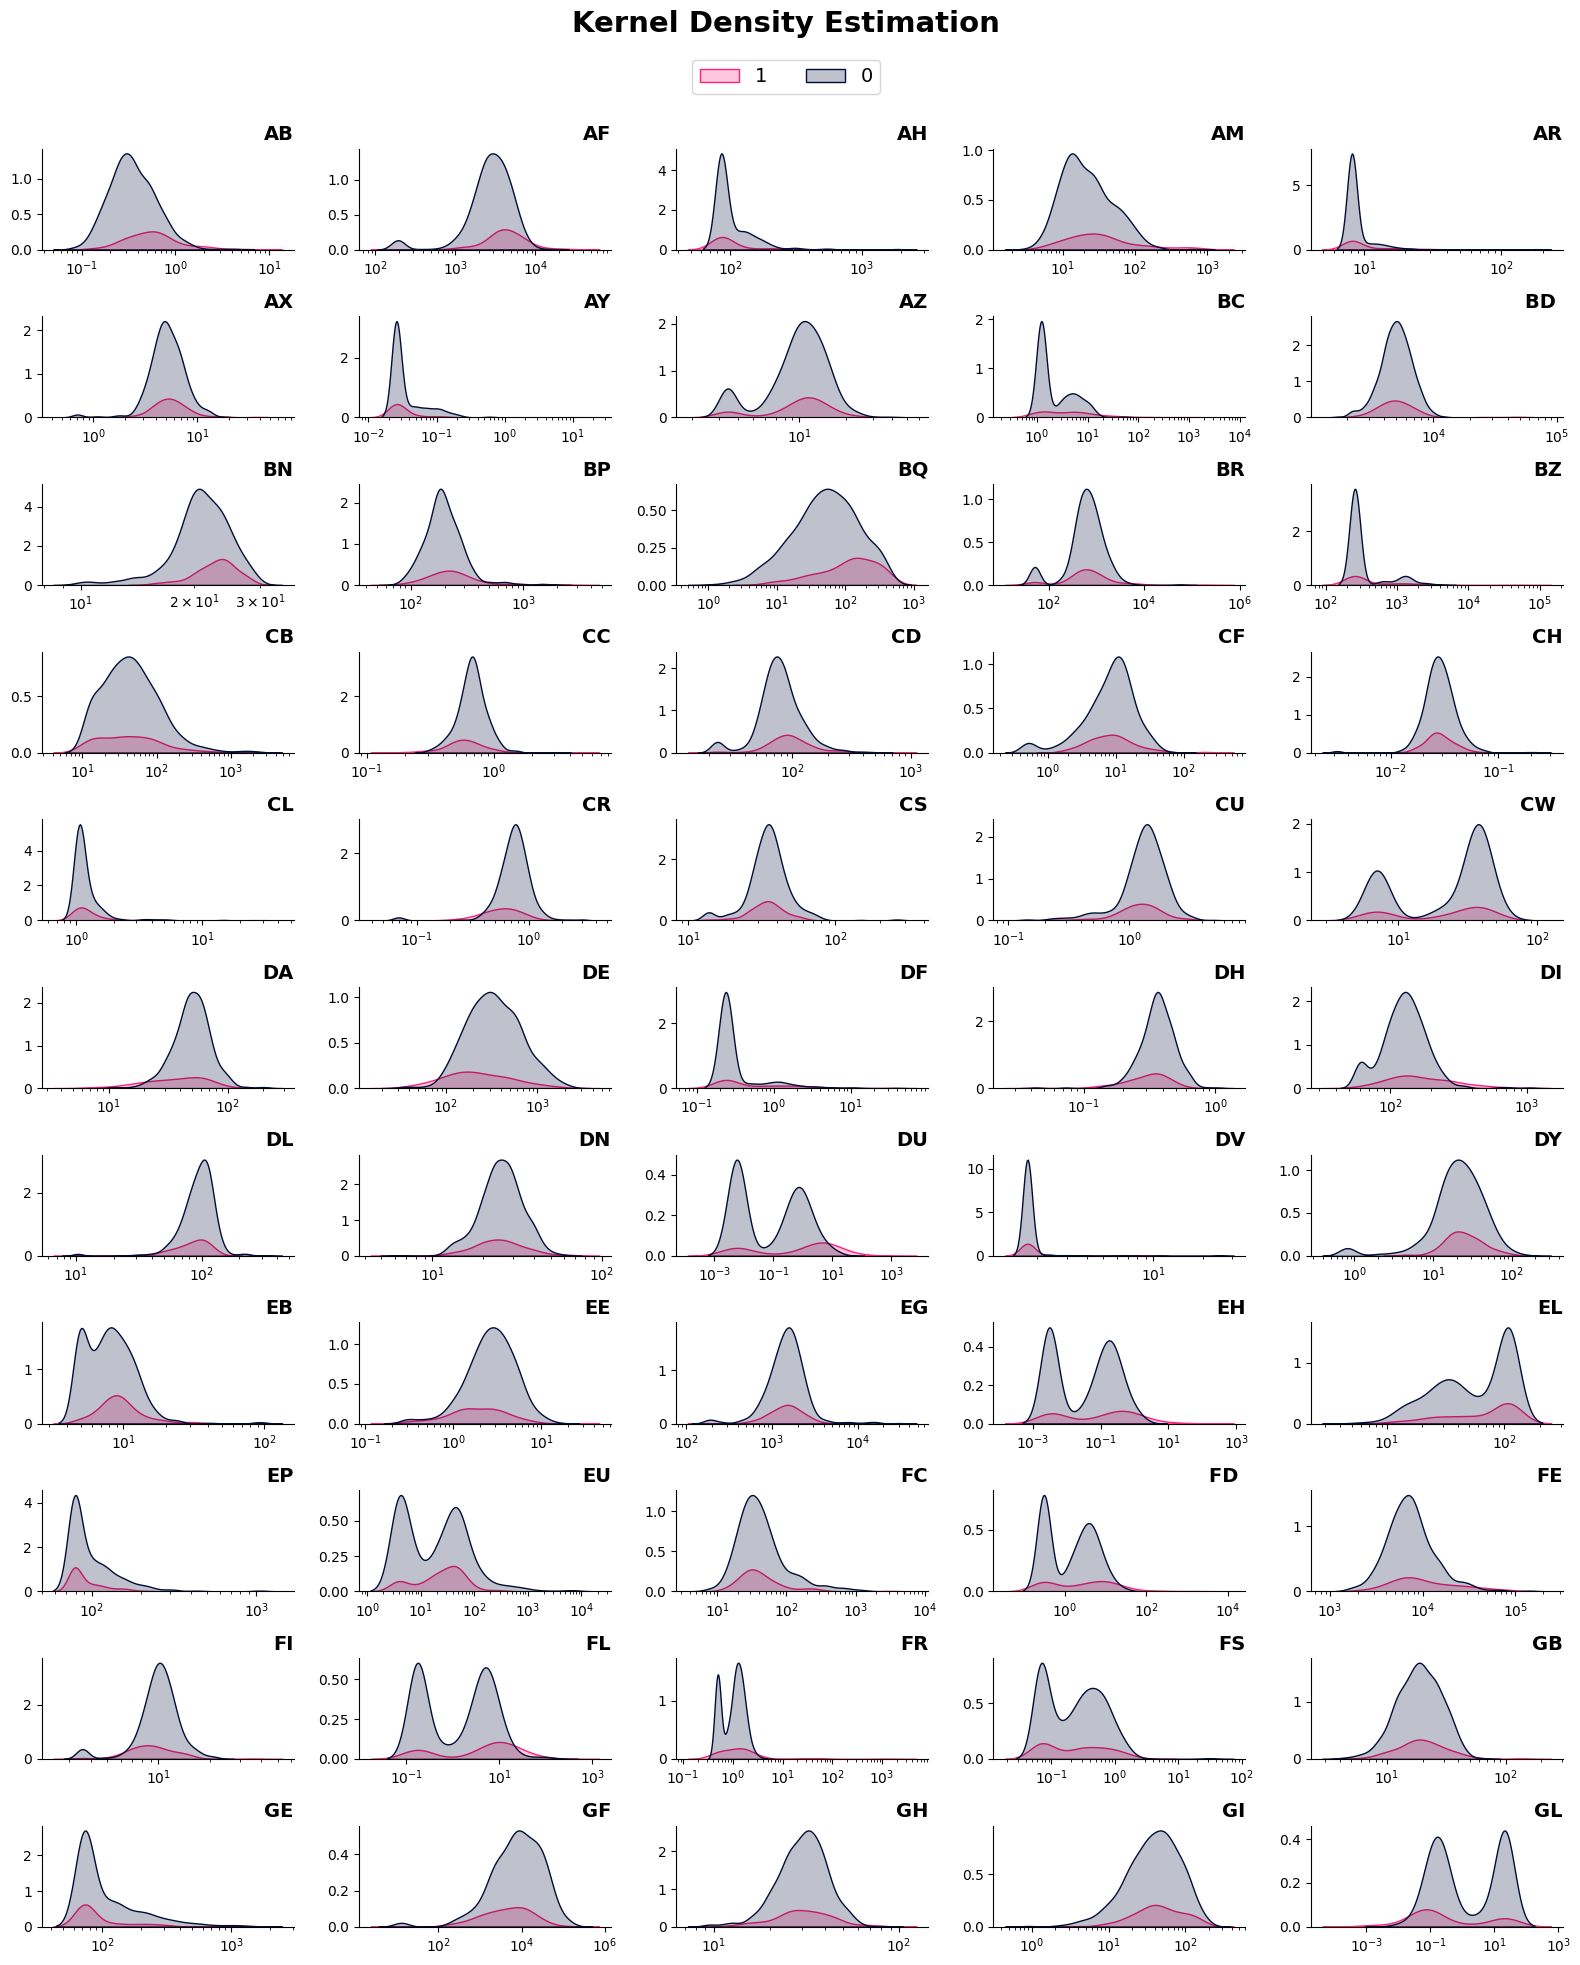

In [18]:
figsize = (4*4, 20)
fig = plt.figure(figsize=figsize)
numeric_columns = ['AB', 'AF', 'AH', 'AM', 'AR', 'AX', 'AY', 'AZ', 'BC', 'BD ', 'BN',
       'BP', 'BQ', 'BR', 'BZ', 'CB', 'CC', 'CD ', 'CF', 'CH', 'CL', 'CR', 'CS',
       'CU', 'CW ', 'DA', 'DE', 'DF', 'DH', 'DI', 'DL', 'DN', 'DU', 'DV', 'DY',
       'EB', 'EE', 'EG', 'EH', 'EL', 'EP', 'EU', 'FC', 'FD ', 'FE', 'FI',
       'FL', 'FR', 'FS', 'GB', 'GE', 'GF', 'GH', 'GI', 'GL']

for idx, col in enumerate(numeric_columns):
    ax = plt.subplot(11,5, idx + 1)
    sns.kdeplot(
        data=train, hue='Class', fill=True,
        x=col, palette=['#010D36','#FF2079'], legend=False, log_scale=True
    )
            
    ax.set_ylabel(''); ax.spines['top'].set_visible(False), 
    ax.set_xlabel(''); ax.spines['right'].set_visible(False)
    ax.set_title(f'{col}', loc='right', 
                 weight='bold', fontsize=14)

fig.suptitle(f'Kernel Density Estimation\n\n\n', ha='center',  fontweight='bold', fontsize=21)
fig.legend([1, 0], loc='upper center', bbox_to_anchor=(0.5, 0.96), fontsize=14, ncol=3)
plt.tight_layout()
plt.show()

Well, here we've got a diversity of variables, i.e. some of them probably relatively good fit a normal distribution, while some have long tails (and extremely long tails), like AR, AY, BR, BZ, etc. Moreover, there are even bimodal distributions.
We will better understand the diversity between classes on the cumulative plots, as below.

## Probability Plots & Transformations

A probability plot, also known as a probability-probability plot or P-P plot, is a graphical tool used in statistics to assess the similarity between the observed data and a specific probability distribution, typically a theoretical distribution like the normal distribution. It helps you visually compare the observed data to the expected distribution to check for goodness-of-fit.

On such a plot, samples which follow normal distribution are deployed on a diagonal straight line.

Some machine learning models assume that the variable follows a normal distribution. In turn, the mentioned technique helps to decide which transformations should be done within the given variable to improve the fit to that distribution.

In [19]:
import plotly.subplots as sp
import plotly.graph_objs as go
import pandas as pd
import scipy.stats as stats
import numpy as np

# Calculate the number of rows and columns for subplots
num_plots = len(numeric_columns)
num_rows = (num_plots + 4) // 5  
num_cols = min(5, num_plots)  
# Create subplots
fig = sp.make_subplots(rows=num_rows, cols=num_cols, subplot_titles=numeric_columns)

# Loop through numeric columns and create PP plots
for i, col in enumerate(numeric_columns):
    row_idx = i // num_cols + 1  # Row index starts from 1
    col_idx = i % num_cols + 1   # Column index starts from 1
    
    # Create a PP plot using scipy's probplot function
    (osm, osr), (slope, intercept, R) = stats.probplot(train[col].dropna(), rvalue=True)
    x_theory = np.array([osm[0], osm[-1]])
    y_theory = intercept + slope * x_theory
    R2 = f"R\u00b2 = {R * R:.2f}"
    
    fig.add_scatter(x=osm, y=osr, mode="markers", row=row_idx, col=col_idx, name=col)
    fig.add_scatter(x=x_theory, y=y_theory, mode="lines", row=row_idx, col=col_idx)
    fig.add_annotation(
        x=-1.25,
        y=osr[-1] * 0.75,
        text=R2,
        showarrow=False,
        row=row_idx,
        col=col_idx,
        font_size=9,
    )
    fig.update_yaxes(tickfont_size=7, row=row_idx, col=col_idx)
    fig.update_xaxes(
        titlefont_size=9,
        titlefont_family="Arial Black",
        tickfont_size=7,
        row=row_idx,
        col=col_idx,
    )

fig.update_layout(
    title="Numerical Features - Probability Plots against Normal Distribution",
    title_font_size=18,
    showlegend=False,
    width=800,
    height=1000,
)
fig.update_traces(
    marker=dict(size=1, symbol="x-thin", line=dict(width=2, color="#010D36")),
    line_color="#FF2079",
)
fig.show()

Some variables fit a normal distribution well, which manifests by a high coefficient of determination (R-squared) and evenly deployed samples around the straight line. These are for example DN or BN.

Nevertheless, there are a lot of features which do not fit the normal one. We can improve that by specific transformations:
- **Log Transformation** - generally works fine with right-skewed data. Requires non-negative numbers.
- **Square Root Transformation** - similarly to log-level transformation. Requires non-negative numbers.
- **Square Transformation** - helps to reduce left-skewed data.
- **Reciprocal Transformation** - used sometimes, when data is skewed, or there are obvious outliers. Not defined at zero.
- **Box-Cox Transformation** - used when data is skewed or has outliers. Requires strictly positive numbers.
- **Yeo-Johnson Transformation** - variation of Box-Cox transformation, but without restrictions concerning numbers.
- Let's check all of these transformations for our variables. We simply use the probplot() function to get R-squared coefficients for each transformation.

In [20]:
from collections import defaultdict
r2_scores = defaultdict(tuple)
for feature in numeric_columns:
    actual = train[feature].dropna()
    _, (*_, R_actual) = stats.probplot(actual, rvalue=True)
    _, (*_, R_log) = stats.probplot(np.log(actual), rvalue=True)
    _, (*_, R_sqrt) = stats.probplot(np.sqrt(actual), rvalue=True)
    _, (*_, R_reci) = stats.probplot(np.reciprocal(actual), rvalue=True)
    _, (*_, R_boxcox) = stats.probplot(stats.boxcox(actual)[0], rvalue=True)
    _, (*_, R_yeojohn) = stats.probplot(stats.yeojohnson(actual)[0], rvalue=True)
    r2_scores[feature] = (
        R_actual * R_actual,
        R_log * R_log,
        R_sqrt * R_sqrt,
        R_reci * R_reci,
        R_boxcox * R_boxcox,
        R_yeojohn * R_yeojohn,
    )

r2_scores = pd.DataFrame(
    r2_scores, index=("Original", "Log", "Sqrt", "Reciprocal", "BoxCox", "YeoJohnson")
).T

r2_scores["Max_R2"] = r2_scores.max(axis=1)
r2_scores["Winner"] = r2_scores.idxmax(axis=1)
r2_scores

,Original,Log,Sqrt,Reciprocal,BoxCox,YeoJohnson,Max_R2,Winner
AB,0.537195,0.976071,0.820288,0.919818,0.998107,0.991143,0.998107,BoxCox
AF,0.761133,0.871797,0.945411,0.344347,0.955054,0.955098,0.955098,YeoJohnson
AH,0.237829,0.567640,0.415764,0.678381,0.686058,0.686064,0.686064,YeoJohnson
AM,0.383144,0.958737,0.715838,0.903156,0.996761,0.995844,0.996761,BoxCox
AR,0.158397,0.421770,0.299171,0.505032,0.515449,0.515495,0.515495,YeoJohnson
AX,0.745500,0.917768,0.912345,0.488744,0.937514,0.950425,0.950425,YeoJohnson
AY,0.038600,0.572584,0.231879,0.641586,0.633691,0.626888,0.641586,Reciprocal
AZ,0.942194,0.902788,0.953193,0.722089,0.956941,0.957626,0.957626,YeoJohnson
BC,0.057783,0.740394,0.308317,0.723142,0.738835,0.744935,0.744935,YeoJohnson
BD,0.412282,0.924370,0.730386,0.918367,0.961509,0.961520,0.961520,YeoJohnson


It seems that the Yeo-Johnson transformation is the most frequently chosen transformation method that produces the highest R-squared value. However, other methods like Box-Cox and Log also appear as winners in some cases.

In [21]:
#Getting columns corresponding to their winning transformations
no_transform_cols = r2_scores[r2_scores["Winner"] == "Original"].index
log_transform_cols = r2_scores[r2_scores["Winner"] == "Log"].index
sqrt_transform_cols = r2_scores[r2_scores["Winner"] == "Sqrt"].index
reciprocal_transform_cols = r2_scores[r2_scores["Winner"] == "Reciprocal"].index
boxcox_transform_cols = r2_scores[r2_scores["Winner"] == "BoxCox"].index
yeojohnson_transform_cols = r2_scores[r2_scores["Winner"] == "YeoJohnson"].index

train_transformed = train.copy()

def transformations(data):
    for col in log_transform_cols:
        data[col] = np.log(data[col])

    # Applying sqrt transformation to specific columns
    for col in sqrt_transform_cols:
        data[col] = np.sqrt(data[col])

    # Applying reciprocal transformation to specific columns
    for col in reciprocal_transform_cols:
        data[col] = 1 / data[col]

    # Applying Box-Cox transformation to specific columns
    for col in boxcox_transform_cols:
        index = data.index[data[col].notna()]
        null_index = data.index[data[col].isna()]
        data.loc[index,col] = stats.boxcox(data.drop(null_index,axis=0)[col])[0]

    # Applying Yeo-Johnson transformation to specific columns
    for col in yeojohnson_transform_cols:
        index = data.index[data[col].notna()]
        null_index = data.index[data[col].isna()]
        data.loc[index,col] = stats.yeojohnson(data.drop(null_index,axis=0)[col])[0]
    return data

train_transformed = transformations(train_transformed)

### Probability Plots - Again!

In [22]:
import plotly.subplots as sp
import plotly.graph_objs as go
import pandas as pd
import scipy.stats as stats
import numpy as np

# Calculate the number of rows and columns for subplots
num_plots = len(numeric_columns)
num_rows = (num_plots + 4) // 5  
num_cols = min(5, num_plots)  
# Create subplots
fig = sp.make_subplots(rows=num_rows, cols=num_cols, subplot_titles=numeric_columns)

semi_const = []
# Loop through numeric columns and create PP plots
for i, col in enumerate(numeric_columns):
    row_idx = i // num_cols + 1  # Row index starts from 1
    col_idx = i % num_cols + 1   # Column index starts from 1
    
    # Create a PP plot using scipy's probplot function
    (osm, osr), (slope, intercept, R) = stats.probplot(train_transformed[col].dropna(), rvalue=True)
    x_theory = np.array([osm[0], osm[-1]])
    y_theory = intercept + slope * x_theory
    R2 = f"R\u00b2 = {R * R:.2f}"
    if R*R < 0.8:
        semi_const.append(col)
        
    fig.add_scatter(x=osm, y=osr, mode="markers", row=row_idx, col=col_idx, name=col)
    fig.add_scatter(x=x_theory, y=y_theory, mode="lines", row=row_idx, col=col_idx)
    fig.add_annotation(
        x=-1.25,
        y=osr[-1] * 0.75,
        text=R2,
        showarrow=False,
        row=row_idx,
        col=col_idx,
        font_size=9,
    )
    fig.update_yaxes(tickfont_size=7, row=row_idx, col=col_idx)
    fig.update_xaxes(
#         title_text=col,
        titlefont_size=9,
        titlefont_family="Arial Black",
        tickfont_size=7,
        row=row_idx,
        col=col_idx,
    )

fig.update_layout(
    title="Numerical Features - Probability Plots against Normal Distribution",
    title_font_size=18,
    showlegend=False,
    width=800,
    height=1000,
)
fig.update_traces(
    marker=dict(size=1, symbol="x-thin", line=dict(width=2, color="#010D36")),
    line_color="#FF2079",
)
fig.show()

In [23]:
#All the variables that did not improve on transformation
semi_const

['AH', 'AR', 'AY', 'BC', 'BZ', 'CL', 'DF', 'DV', 'EP', 'GE']

As you can see above, the transformations works perfectly for some variables.
Sometimes models like SVC handle very well, and appropriate transformations for these algorithms are crucial.
Let's look closely at these values we've got.

There is something problematic with some variables, i.e., these that have especially poor transformation results. Let's specify, and look at them closely: 

**AH,AY,AR, BZ, DF, and DV**

In [24]:
#Let's see whats in there for the worst ones
train[["AH","AY","AR","BZ","DF","DV"]]

,AH,AY,AR,BZ,DF,DV
0,85.200147,0.025578,8.138688,257.432377,0.238680,1.74307
1,85.200147,0.025578,8.138688,257.432377,0.238680,1.74307
2,85.200147,0.025578,8.138688,257.432377,0.238680,1.74307
3,120.201618,0.025578,8.138688,257.432377,0.238680,1.74307
4,85.200147,0.054810,8.138688,257.432377,0.238680,1.74307
...,...,...,...,...,...,...
612,123.763599,0.077343,13.020852,257.432377,0.238680,2.41906
613,85.200147,0.025882,15.973224,257.432377,0.238680,1.74307
614,130.138587,0.025578,10.005552,257.432377,0.238680,1.74307
615,85.200147,0.025578,8.138688,257.432377,0.532818,1.74307


In [25]:
problematic_cols = train[["AH","AY","AR","BZ","DF","DV"]]
print("% of Duplicate Entries", problematic_cols.duplicated().sum()/problematic_cols.shape[0])

% of Duplicate Entries 0.29983792544570503


Okay, there we have just mostly the **same value for the whole variable**. That's the reason for weak transformations.
**It's good to check other semi-constant variables.**

In [26]:
semi_const = ["AH","AY","AR","BC","BZ","CL","DF","DV","EP","GE"]
semi_const_class = semi_const + ["Class"]
train[semi_const_class].corr()["Class"]

AH       0.044645
AY       0.082420
AR       0.064380
BC       0.155882
BZ       0.112423
CL       0.016852
DF       0.064272
DV       0.015477
EP      -0.068383
GE      -0.070766
Class    1.000000
Name: Class, dtype: float64

**Weak correlations with Class. These features can be binarized.**

In [27]:
import pandas as pd

def binarize_columns_by_mean(data, columns_to_binarize, threshold=None):
    """
    Binarize columns in a DataFrame based on their mean.
    """
    # Calculate the mean of each column
    column_means = data[columns_to_binarize].mean()
    if threshold is None:
        threshold = column_means
    data_binarized = data[columns_to_binarize] > threshold
    data = pd.concat([data, data_binarized], axis=1)
    data.drop(columns=columns_to_binarize, inplace=True)
    return data

train_transformed = binarize_columns_by_mean(train_transformed, ["AH", "AY", "AR", "BC", "BZ", "CL", "DF", "DV", "EP", "GE"])

### Categorical Variables: EJ

In the whole dataset, there is only one categorical feature - EJ. Let's focus on this.

In [28]:
import plotly.express as px

# Data
plot_df = train.groupby(["EJ","Class"])["Id"].count().reset_index()
plot_df.columns = ['EJ', 'Class', 'Count']

# Create a nested donut chart
fig = px.sunburst(
    plot_df,
    path=['EJ', 'Class'],
    values='Count',
    color='EJ',
    color_discrete_sequence=["Black", "Light Blue"],
)
fig.update_layout(title='Nested Donut Chart - EJ Value Proportion in Training Data')

# Calculate proportions
total_counts = plot_df['Count'].sum()
plot_df['Proportion'] = plot_df['Count'] / total_counts

# Add custom labels with proportions and counts
fig.update_traces(
    textinfo='label+percent entry+value',
    texttemplate="Class %{label}<br>%{value}<br>%{percentParent}",
    hovertemplate='<b>%{label}</b><br>Count: %{value}<br>Proportion: %{percentEntry}',
    textfont_size=14,
    insidetextorientation='horizontal',  # Horizontal percentage labels
)

# Show the chart
fig.show()


## Modelling
Started off with simple baseline models, and then used GridSearchCV to tune Hyperparameters. A combination of tree-based models and SVMs worked pretty well.

In [29]:
def balanced_log_loss(y_true,y_prob,y_pred=None,**kwargs):
    """Competition evaluation metric - balanced logarithmic loss.
    The overall effect is such that each class is roughly equally
    important for the final score."""
    if y_pred is None:
        y_pred = (y_prob >= 0.5).astype(int)
        
    N0, N1 = np.bincount(y_true)
    y0 = np.where(y_true == 0, 1, 0)
    y1 = np.where(y_true == 1, 1, 0)

    eps = kwargs.get("eps", 1e-15)
    y_pred = np.clip(y_pred, eps, 1 - eps)
    p0 = np.log(1 - y_pred)
    p1 = np.log(y_pred)

    return -(1 / N0 * np.sum(y0 * p0) + 1 / N1 * np.sum(y1 * p1)) * 0.5


In [30]:
def preprocess(df):
    df['EJ'].replace({"A":0,"B":1},inplace=True)
    X = df.drop(["Id","Class"],axis=1).apply(lambda x:x.fillna(x.mean()))
    y = df["Class"]
    return X,y

In [31]:
def evaluate(y_true,y_pred):
    # Calculate the confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Plot the confusion matrix with color using seaborn
    plt.figure(figsize=(4,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', linewidths=0.5, cbar=False)
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()

    # Generate and print the classification report
    class_report = classification_report(y_val, y_pred, target_names=['Class 0', 'Class 1'])
    print("Classification Report:\n", class_report)
    print("Log_Loss:",balanced_log_loss(y_true,y_pred))

In [32]:
X,y = preprocess(train_transformed)

# Split the data into training, validation, and test sets with stratified sampling
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Apply SMOTE to the training data only
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)   

In [33]:
# from lightgbm import LGBMClassifier

# # Define the parameter grid for hyperparameter tuning, optimal ranges were choosen after trial and error
# lgbm_params = {
#     "max_depth": [2,3,5],
#     "num_leaves": [2,4,6],
#     "min_child_samples": [11,13,17],
#     "n_estimators": [100,200,300],
#     "learning_rate": [0.10,0.15,0.20],
#     "colsample_bytree": [0.2,0.4,0.6],
#     "min_split_gain": [1e-2,1e-3,1e-4],
#     "reg_alpha": [1e-1,1e-2,1e-3],
#     "reg_lambda": [5e-1,5e-2,5e-3]
# }
# # Create a RandomForestClassifier
# lgbm_classifier = LGBMClassifier(random_state=42)

# # Create a GridSearchCV object with custom scoring function
# grid_search = GridSearchCV(
#     estimator=lgbm_classifier,
#     param_grid=lgbm_params,
#     scoring=make_scorer(balanced_log_loss, greater_is_better=False),  # Use the custom scoring function
#     cv=5,  # Cross-validation folds
#     n_jobs=-1  # Use all available CPU cores
# )

# # Fit the grid search to the data
# grid_search.fit(X_train, y_train)

# # Get the best estimator and best hyperparameters
# best_lgbm_classifier = grid_search.best_estimator_
# best_params = grid_search.best_params_

# # Calculate the average log loss across cross-validation folds
# log_loss_values = -grid_search.cv_results_['mean_test_score']
# average_log_loss = np.mean(log_loss_values)

# print("Average_Log_Loss:",average_log_loss)
# print("Best Random Forest Classifier:", best_lgbm_classifier)
# print("Best Hyperparameters:", best_params)

In [34]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from scipy import stats

class CustomPreprocessor(BaseEstimator, TransformerMixin):
    def __init__(self, log_transform_cols, sqrt_transform_cols, reciprocal_transform_cols, boxcox_transform_cols,
                 yeojohnson_transform_cols, kind = "train"):
        self.log_transform_cols = log_transform_cols
        self.sqrt_transform_cols = sqrt_transform_cols
        self.reciprocal_transform_cols = reciprocal_transform_cols
        self.boxcox_transform_cols = boxcox_transform_cols
        self.yeojohnson_transform_cols = yeojohnson_transform_cols
        self.kind = kind

    def fit(self, data, y=None):
        return self

    def transform(self,data):
        X, y = self.preprocess(data,self.kind)
        X = self.transformations(X)
        X = self.binarize_columns_by_mean(X, ["AH", "AY", "AR", "BC", "BZ", "CL", "DF", "DV", "EP", "GE"])
        return X, y

    def transformations(self, data):
        for col in self.log_transform_cols:
            data[col] = np.log(data[col])

        for col in self.sqrt_transform_cols:
            data[col] = np.sqrt(data[col])

        for col in self.reciprocal_transform_cols:
            data[col] = 1 / data[col]

        for col in self.boxcox_transform_cols:
            index = data.index[data[col].notna()]
            null_index = data.index[data[col].isna()]
            data.loc[index, col] = stats.boxcox(data.drop(null_index, axis=0)[col])[0]

        for col in self.yeojohnson_transform_cols:
            index = data.index[data[col].notna()]
            null_index = data.index[data[col].isna()]
            data.loc[index, col] = stats.yeojohnson(data.drop(null_index, axis=0)[col])[0]
        return data

    def binarize_columns_by_mean(self, data, columns_to_binarize, threshold=None):
        column_means = data[columns_to_binarize].mean()
        if threshold is None:
            threshold = column_means
        data_binarized = data[columns_to_binarize] > threshold
        data = pd.concat([data, data_binarized], axis=1)
        data.drop(columns=columns_to_binarize, inplace=True)
        return data

    def preprocess(self, df, kind = "train"):
        df['EJ'].replace({"A": 0, "B": 1}, inplace=True)
        if kind == "train":
            X = df.drop(["Id", "Class"], axis=1).apply(lambda x: x.fillna(x.mean()))
            y = df["Class"]
        else:
            X = df.drop(["Id"], axis=1).apply(lambda x: x.fillna(x.mean()))
            y = np.nan
            
        return X, y
    
# Create the preprocessing transformer
preprocessor = CustomPreprocessor(
    log_transform_cols=['DU', 'EL', 'EU', 'FD ', 'FS'],
    sqrt_transform_cols=[],
    reciprocal_transform_cols=['AY', 'BZ', 'DF', 'EP', 'GE'],
    boxcox_transform_cols=['AB', 'AM', 'BN', 'BQ', 'CB', 'CL', 'DV', 'GI', 'GL'],
    yeojohnson_transform_cols=['AF', 'AH', 'AR', 'AX', 'AZ', 'BC', 'BD ', 'BP', 'BR', 'CC', 'CD ',
       'CF', 'CH', 'CR', 'CS', 'CU', 'DA', 'DE', 'DH', 'DI', 'DL', 'DN', 'DY',
       'EB', 'EE', 'EG', 'EH', 'FC', 'FE', 'FI', 'FL', 'FR', 'GB', 'GF', 'GH'])


In [35]:
# Create a pipeline to preprocess the data
preprocess = make_pipeline(
            preprocessor
)

X,y = preprocess.fit_transform(train)

# Split the data into training, validation, and test sets with stratified sampling
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Scale the data using a scaler
scale = StandardScaler()
X_train = scale.fit_transform(X_train)
X_val = scale.transform(X_val)

# Apply SMOTE to the training data only
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)


# Define parameters here
lgbm_params = {
    "max_depth": 3,
    "num_leaves": 8,
    "min_child_samples": 17,
    "n_estimators": 200,
    "learning_rate": 0.15,
    "colsample_bytree": 0.4,
    "min_split_gain": 1e-4,
    "reg_alpha": 1e-2,
    "reg_lambda": 5e-3,
}
xgb_params = {
    "max_depth": 2,
    "n_estimators": 200,
    "learning_rate": 0.4,
    "subsample": 0.6,
    "min_child_weight": 0.1,
    "max_delta_step": 0.35,
    "colsample_bytree": 0.3,
    "colsample_bylevel": 0.7,
    "min_split_loss": 1e-4,
    "reg_alpha": 2e-3,
    "reg_lambda": 6e-2,
}
svc_params = {
    "probability": True,
    "C": 3,
}

# Create a pipeline with the VotingClassifier
current_ensemble = make_pipeline(
    VotingClassifier(
        estimators=[
            ("lgbm",LGBMClassifier(random_state=42, **lgbm_params)),
            ("xgb", xgb.XGBClassifier(random_state=42, **xgb_params)),
            ("svc", SVC(random_state=42, **svc_params)),
        ],
        voting="soft",
        weights=(0.46, 0.46, 0.08),
    ),
)

# Fit the ensemble on the training data
current_ensemble.fit(X_train_resampled, y_train_resampled)

# Make predictions on the validation set
y_pred_prob = current_ensemble.predict_proba(X_val)[:, 1]

# Convert probabilities to binary predictions
y_pred = (y_pred_prob >= 0.5).astype(int)

# Calculate Log Loss
logloss = log_loss(y_val, y_pred_prob)
print(f"Log Loss: {logloss:.4f}")

# Calculate accuracy
accuracy = accuracy_score(y_val, y_pred)
print(f"Accuracy: {accuracy:.4f}")

Log Loss: 0.1659
Accuracy: 0.9355


# Visualize the model

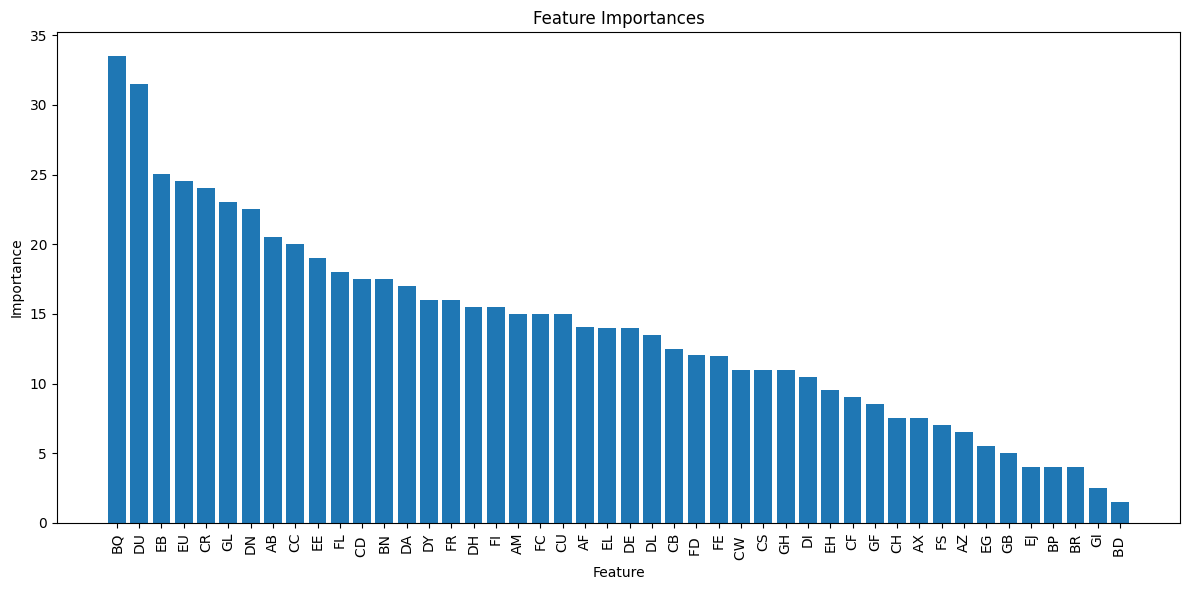

In [36]:
# Extract feature importances from the individual models
lgbm_feature_importances = current_ensemble.named_steps['votingclassifier'].estimators_[0].feature_importances_
xgb_feature_importances = current_ensemble.named_steps['votingclassifier'].estimators_[1].feature_importances_
# Note: You may need to adjust the above lines depending on the naming of your estimators in the VotingClassifier.

# Combine feature importances (you can use different strategies, such as averaging or summing)
feature_importances = (lgbm_feature_importances + xgb_feature_importances) / 2
feature_names = X.columns

# Sort feature importances and corresponding feature names in descending order
sorted_indices = np.argsort(feature_importances)[::-1]
sorted_feature_importances = feature_importances[sorted_indices]
sorted_feature_names = feature_names[sorted_indices]

# Create a bar plot to visualize feature importances
plt.figure(figsize=(12, 6))
plt.bar(range(len(sorted_feature_importances)), sorted_feature_importances)
plt.xticks(range(len(sorted_feature_importances)), sorted_feature_names, rotation=90)
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.title('Feature Importances')
plt.tight_layout()
plt.show()

# Submission

In [37]:
test = pd.read_csv('/kaggle/input/icr-identify-age-related-conditions/test.csv')

In [39]:
# # Create the preprocessing transformer for test
# preprocessor = CustomPreprocessor(
#     log_transform_cols=['DU', 'EL', 'EU', 'FD ', 'FS'],
#     sqrt_transform_cols=[],
#     reciprocal_transform_cols=['AY', 'BZ', 'DF', 'EP', 'GE'],
#     boxcox_transform_cols=['AB', 'AM', 'BN', 'BQ', 'CB', 'CL', 'DV', 'GI', 'GL'],
#     yeojohnson_transform_cols=['AF', 'AH', 'AR', 'AX', 'AZ', 'BC', 'BD ', 'BP', 'BR', 'CC', 'CD ',
#        'CF', 'CH', 'CR', 'CS', 'CU', 'DA', 'DE', 'DH', 'DI', 'DL', 'DN', 'DY',
#        'EB', 'EE', 'EG', 'EH', 'FC', 'FE', 'FI', 'FL', 'FR', 'GB', 'GF', 'GH'],kind="test")


# preprocessor.transform(test)

In [40]:
# Xtest = test_df.drop(["Id"],axis=1)
# Xtest['EJ'].replace({"A":0,"B":1},inplace=True)

In [41]:
# sample_submission = pd.read_csv("/kaggle/input/icr-identify-age-related-conditions/sample_submission.csv")
# sample_submission['class_0'] = class_0
# sample_submission['class_1'] = class_1
# sample_submission.to_csv('/kaggle/working/submission.csv', index=False)

In [42]:
# sample_submission